The data here comes from the competition experiment between two strains shown in Figure 5. These strains were grown in coculture over 4 growth-dilution cycles at two pH values (6 and 7.3) and over a number of initial relative abundances (see below). 16S amplicon sequencing was performed on samples from the end of each cycle. Known relative abundance controls were used to infer sample relative abundances from raw counts. 

The following code illustrates the structure of the 16S data. The data itself consists of an asv table (data/asv_table_final.csv) in which each row is an asv, and each column is an experimental condition. Each matrix element is the number of counts of each asv in each condition. 

The metadata file data/metadata.csv specifies each experimental condition, as indicated below. 

In [1]:
#import necessary modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from scipy.optimize import curve_fit

In [2]:
#load asv and metadata files
asv_file = pd.read_csv('data/asv_table_final.csv', header = 0)
metadata_file = pd.read_csv('data/metadata.csv', index_col=0, header = 0)

Below, I sort each ASV by its taxonomy. Note that asv_file.loc[i][0] provides the ASV ID (it's labelled "OTU ID" but these are ASVs). The sequences associated with the IDs can be found in "data/dna-sequences.fasta"

total rhizo counts are 3852620.0
total pseudo counts are 6434578.0
total other counts are 18185.0
overall other fraction is 0.0017646117567876904
max other fraction in well is 0.007749240890688259



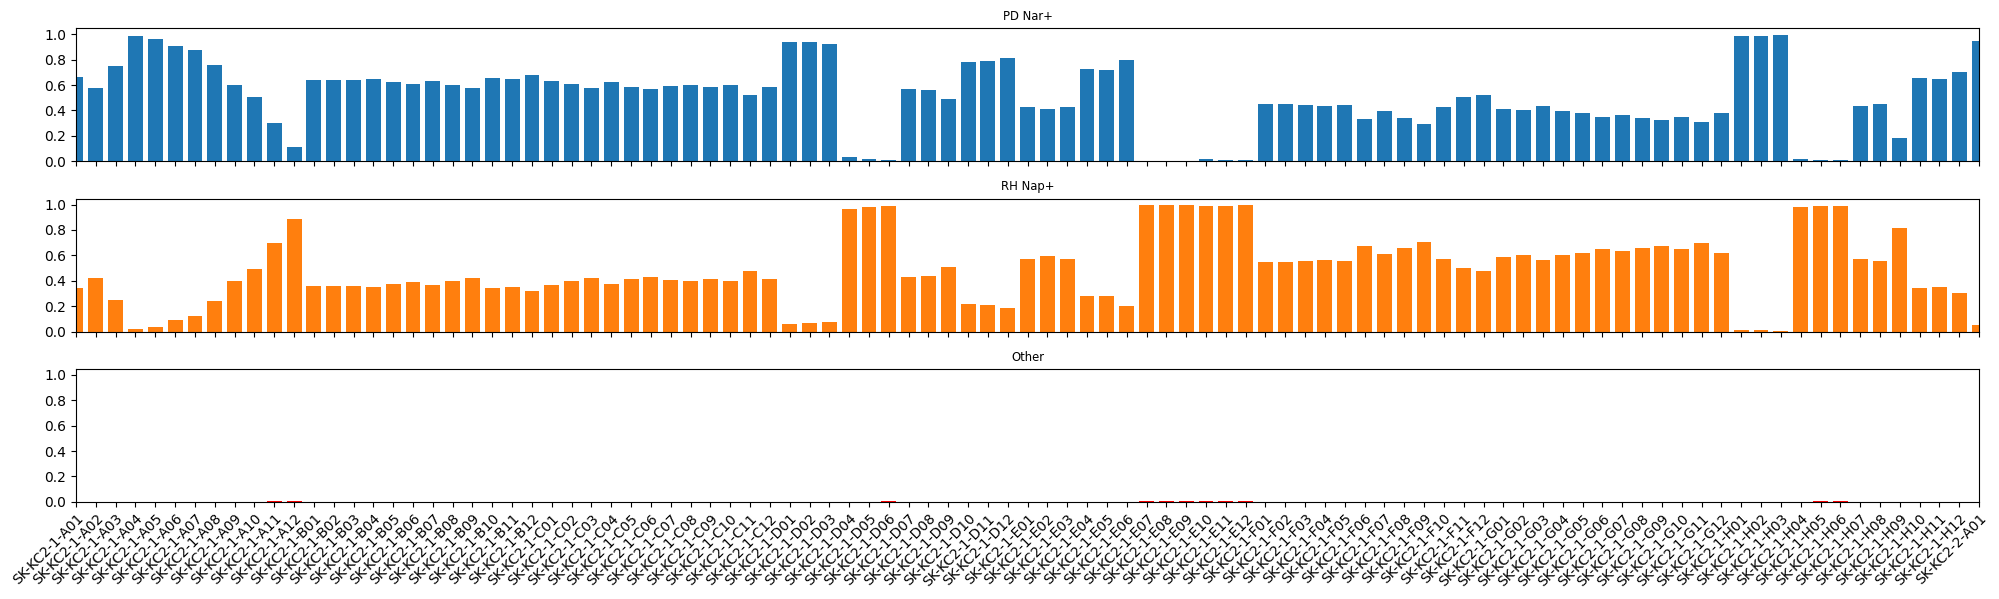

In [3]:
#prepare arrays for data sorting
wells = []
pseudo_rel_abs = []
rhizo_rel_abs = []
pseudo_counts = []
rhizo_counts = []
other_counts = []
other_rel_abs = []
cycles = []
pHs = []
rhizo_f0s = []
tot_rhizo_counts = 0
tot_pseudo_counts = 0
tot_other_counts = 0


##################################################
#sort by taxonomy in each experimental condition#
##################################################
for j in range(len(asv_file.loc[0][:])):
    p_sum = 0
    r_sum = 0
    other = 0
    if asv_file.loc[0][j] != 'taxonomy':
        if asv_file.loc[0][j] != '#OTU ID':
            if asv_file.loc[0][j] != 'Undetermined':  #ignore DNA whose experimental condition was undetermined
                #print(asv_file.loc[0][j])
                for i in range(1,len(asv_file.loc[:])):
                    #print(asv_file.loc[i][-1])
                    if 'Pseudomonas' in asv_file.loc[i][-1]:
                        #print('pseudo hit')
                        #print(asv_file.loc[0][j])
                        #print(asv_file.loc[i][j])
                        #print('val to add is ' + str(asv_file.loc[i][j]))
                        p_sum = p_sum + float(asv_file.loc[i][j])
                        tot_pseudo_counts = tot_pseudo_counts + float(asv_file.loc[i][j]) 
                    elif 'Rhizobiaceae' in asv_file.loc[i][-1]:
                        #print('rhizo hit')
                        #print(asv_file.loc[0][j])
                        #print(asv_file.loc[i][j])
                        #print('val to add is ' + str(asv_file.loc[i][j]))
                        r_sum = r_sum + float(asv_file.loc[i][j])
                        tot_rhizo_counts = tot_rhizo_counts + float(asv_file.loc[i][j])
                    else:  #small amounts of non-pseudomonas/rhizobiaceae asvs
                        #print('rhizo hit')
                        #print(asv_file.loc[0][j])
                        #print(asv_file.loc[i][j])
                        #print('val to add is ' + str(asv_file.loc[i][j]))
                        tot_other_counts = tot_other_counts + float(asv_file.loc[i][j])
                        other = other + float(asv_file.loc[i][j])
                    #print('')
                wells.append(asv_file.loc[0][j])
                
                
                
                ##############################
                ##### GET METADATA ###########
                ##############################
                rhizo_f0s.append(metadata_file.at[asv_file.loc[0][j],"rhizo_f0"]) #get input relative abundance of the rhizo strain 
                
                pHs.append(metadata_file.at[asv_file.loc[0][j],"pH"])        #get pH 
                cycles.append(metadata_file.at[asv_file.loc[0][j],"cycle"])  #get growth cycle
                #total_sum = p_sum + r_sum + other
                
                
                ####################################
                ####calculate relative abundances###
                ####################################
                total_sum = p_sum + r_sum 
                pseudo_rel_abs.append(p_sum/total_sum)  
                #if p_sum/total_sum > 0.95:
                    #print(p_sum/total_sum)
                    #print('')
                rhizo_rel_abs.append(r_sum/total_sum)
                rhizo_counts.append(r_sum)
                pseudo_counts.append(p_sum)
                other_counts.append(other)
                other_rel_abs.append(other/total_sum)
                #if metadata_file.at[asv_file.loc[0][j],"cycle"] == 0:
                    #print('expected val = ' + str(1- metadata_file.at[asv_file.loc[0][j],"rhizo_f0"]))
                    #print('actual val = ' + str(p_sum/total_sum))
                

print('total rhizo counts are ' + str(tot_rhizo_counts))
print('total pseudo counts are ' + str(tot_pseudo_counts))
print('total other counts are ' + str(tot_other_counts))
print('overall other fraction is ' + str(tot_other_counts/ ( tot_other_counts + tot_pseudo_counts + tot_rhizo_counts)))
print('max other fraction in well is '  + str(max(other_rel_abs)))
print('')

plt.style.use('default')
fig, axs = plt.subplots(3,1,sharex=True, sharey=True,figsize=(20,6))
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['xtick.labelsize'] = 4
plt.rcParams['text.usetex'] = False
plt.rcParams['font.size'] = 7
plt.rcParams['font.family'] = 'Arial'
bar_width = 0.75

#######################################################################################################
### show taxonomy-sorted content in each condition by relative abundance (low "other" indicates lack of contamination)###
#####################################################################################################

axs[0].bar(range(len(pseudo_rel_abs)), pseudo_rel_abs, width = bar_width, color = 'tab:blue')
axs[0].set_title('PD Nar+')
axs[1].bar(range(len(rhizo_rel_abs)), rhizo_rel_abs, width = bar_width, color = 'tab:orange')
axs[1].set_title('RH Nap+')
axs[2].bar(range(len(other_rel_abs)), other_rel_abs, width = bar_width, color = 'red')
axs[2].set_title('Other')
'''
axs[0].bar(range(len(pseudo_counts)), pseudo_counts, width = bar_width, color = 'tab:blue')
axs[0].set_title('PD Nar+')
axs[1].bar(range(len(rhizo_counts)), rhizo_counts, width = bar_width, color = 'tab:orange')
axs[1].set_title('RH Nap+')
axs[2].bar(range(len(other_counts)), other_counts, width = bar_width, color = 'red')
axs[2].set_title('Other')
'''
axs[2].set_xticks(range(len(wells)))
axs[2].set_xticklabels(labels=wells)
plt.setp(axs[2].get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")#, fontsize = 2)
#plt.xlim([96,192])
plt.xlim([0,96])
fig.tight_layout()
#plt.suptitle('raw counts')
plt.show()

fit val is 4.296525543783746+-0.6945472389108396


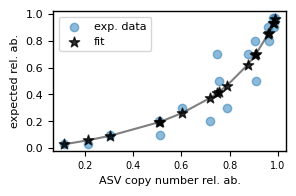

In [4]:
###################################################################################################
##### INFER "TRUE" RELATIVE ABUNDANCES (BY OD) from known relative abundance controls ############
###################################################################################################

plt.style.use('default')
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['xtick.labelsize'] = 7
plt.rcParams['text.usetex'] = False
plt.rcParams['font.size'] = 8

fig, axs = plt.subplots(1,1,sharex=True, sharey=True,figsize=(3,2))
'''
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['xtick.labelsize'] = 4
plt.rcParams['text.usetex'] = False
plt.rcParams['font.size'] = 8
plt.rcParams['font.family'] = 'Arial'
'''
linewidth = 2

meas_p_counts = []
meas_r_counts = []
exp_rel_abs = []
for i in range(len(wells)):
    if cycles[i] == 0:   ###cycle = 0 indicates the known relative abundance control (i.e. sample was taken before experiment was started)
        meas_p_counts.append(pseudo_counts[i])
        meas_r_counts.append(rhizo_counts[i])
        exp_rel_abs.append(1-rhizo_f0s[i])
        #axs.scatter(pseudo_rel_abs[i], 1-rhizo_f0s[i], color = 'k', alpha = 0.1)
axs.scatter(np.asarray(meas_p_counts)/(np.asarray(meas_p_counts) + np.asarray(meas_r_counts)), exp_rel_abs, color = 'tab:blue', alpha = 0.5, label = 'exp. data') #plot expected relative abundance vs true relative abundance by count
#axs.scatter(meas_r_counts/(meas_p_counts + meas_r_counts), 1-exp_rel_abs, color = 'tab:orange')

#####################################################################################################################################
##### define some functions to infer true relative abundance under the assumption that raw counts have some bias factor b ###########
######################################################################################################################################
def fit_func(x, a, b):
    # Curve fitting function
    return a * x**2 + b * x

def fit_func_counts(C, b):
    # Curve fitting function
    p, r = C
    return p  / (p + r * b)

def rel_ab_calc_error(C, b, sigma_b):
    p, r = C
    return sigma_b * p * r / ((p + r * b)**2)

def error_of_avgs(errors):
    quad_sum = 0
    for i in range(len(errors)):
        quad_sum = quad_sum  + errors[i] * errors[i]
    return np.sqrt(quad_sum)/len(errors)

p0 = 1.0
params = curve_fit(fit_func_counts, (np.asarray(meas_p_counts), np.asarray(meas_r_counts)), exp_rel_abs, p0)
[b] = params[0]
[sigma_b] = np.sqrt(np.diag(params[1]))
x_vals = np.linspace(0,1)

print('fit val is ' + str(b)+'+-'+str(sigma_b))

axs.plot(np.sort(np.asarray(meas_p_counts)/(np.asarray(meas_p_counts) + np.asarray(meas_r_counts))), np.sort(fit_func_counts((np.asarray(meas_p_counts), np.asarray(meas_r_counts)),b)), alpha = 0.5, color = 'k')
axs.scatter(np.asarray(meas_p_counts)/(np.asarray(meas_p_counts) + np.asarray(meas_r_counts)), fit_func_counts((np.asarray(meas_p_counts), np.asarray(meas_r_counts)),b), alpha = 0.8, marker = '*', s = 60, color = 'k', label = 'fit')

axs.set_ylabel('expected rel. ab.')
axs.set_xlabel('ASV copy number rel. ab.')
axs.legend()#prop={'size': 15})
fig.tight_layout()
plt.savefig('rel_ab_fits.svg')
plt.savefig('rel_ab_fits.png')
plt.show()

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


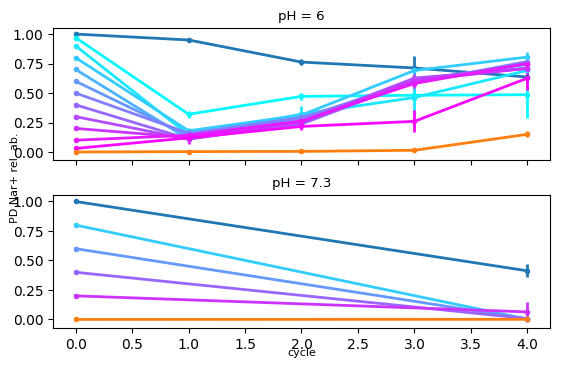

In [5]:
#######################################################################
####### Finally, plot relative abundance dynamics across cycles #######
#######################################################################

plt.style.use('default')
fig, axs = plt.subplots(2,1,sharex=True, sharey=True,figsize=(6,4))
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['xtick.labelsize'] = 4
plt.rcParams['text.usetex'] = False
plt.rcParams['font.size'] = 8
plt.rcParams['font.family'] = 'Arial'
linewidth = 2
markersize = 3.0

#specify initial relative abundances and pH conditions
pHs_vals = [6, 7.3]
rhizo_f0s_vals = [0,0.03,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.97,1] 
cmap = cm.get_cmap('cool')
nar_rel_abs = np.zeros((len(pHs_vals), len(rhizo_f0s_vals), 5))
nar_rel_abs_stds = np.zeros((len(pHs_vals), len(rhizo_f0s_vals), 5))

for j in range(len(pHs_vals)):
    for k in range(len(rhizo_f0s_vals)):
        for l in range(5):
            if l == 0:
                nar_rel_abs[j,k,l] = 1 - rhizo_f0s_vals[k]
                #nar_rel_abs[j,k,l] = rhizo_f0s_vals[k]
                nar_rel_abs_stds[j,k,l] = 0
            else:
                vals = []
                errors = []
                for i in range(len(wells)):
                    if pHs[i] == pHs_vals[j] and rhizo_f0s[i] == rhizo_f0s_vals[k] and cycles[i] == l:
                        vals.append(fit_func_counts((pseudo_counts[i], rhizo_counts[i]), b))      #convert raw counts to "true" relative abundances
                        errors.append(rel_ab_calc_error((pseudo_counts[i], rhizo_counts[i]), b, sigma_b))
                if len(vals)>0:
                    nar_rel_abs[j,k,l] = np.mean(vals)
                    nar_rel_abs_stds[j,k,l] = np.sqrt(np.std(vals)**2 + error_of_avgs(errors)**2)
                    #print('WARNING, IGNORING ERROR DUE TO CALIBRATION FIT')
#print(nar_rel_abs)

#now save processed data
np.savez('processed_data/rel_ab_dynamics.npz', nar_rel_abs = nar_rel_abs, nar_rel_abs_stds = nar_rel_abs_stds, pHs_vals = pHs_vals, rhizo_f0s_vals = rhizo_f0s_vals) 
for j in range(len(pHs_vals)):
    for k in range(len(rhizo_f0s_vals)):
        if rhizo_f0s_vals[k] == 0:
            color_val = 'tab:blue'
        elif rhizo_f0s_vals[k] == 1:
            color_val = 'tab:orange'
        else:
            color_val = cmap(rhizo_f0s_vals[k])
        if pHs_vals[j] == 7.3:
            if nar_rel_abs[j,k,-1] != 0:
                axs[j].errorbar([0,4], [nar_rel_abs[j,k,0],nar_rel_abs[j,k,-1]], yerr = [nar_rel_abs_stds[j,k,0],nar_rel_abs_stds[j,k,-1]], marker = 'o', markersize = markersize, color = color_val, ecolor = color_val, linewidth = linewidth)
        else:
            axs[j].errorbar(range(5), nar_rel_abs[j,k,:], yerr = nar_rel_abs_stds[j,k,:], marker = 'o', markersize = markersize, color = color_val,  ecolor = color_val, linewidth = linewidth)
        axs[j].set_title('pH = ' + str(pHs_vals[j]))

fig.add_subplot(111, frameon=False)

# hide tick and tick label of the big axes                                                                                                                                   
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.ylabel('PD Nar+ rel. ab.')
plt.xlabel("cycle", fontsize = 8)
plt.savefig('rel_ab_dynamics.png')
fig.tight_layout()
plt.show()

    